In [2]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import math
import matplotlib.pyplot as plt


"""
_______________________________________________________________________________________________
"""

class GrowthFunction:
    def __init__(self, h=0.73, omega_m=0.27,omega_l=0.73):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.H_0=((h*100*u.km*u.s**-1*u.Mpc**-1).to(u.Gyr**-1)).value
        self.h=h
    
    """
    We need to create a growth factor function. Which depends on the cosmological model.
    1) find the evolution of the densities
    2) define the growth factor
    """

    def Time(self, z):
        return 2/3/(1+z)**(3/2)/self.H_0

    #hubble
    def E_of_z(self, redshift):
        """
        E(z) which describe the evolution of H(z)=E(z)*H0
        """
        Ez = (self.omega_l0 + (1.0 - self.omega_l0 
            - self.omega_m0) * (1.0+redshift)**2 
            + self.omega_m0 * (1.0+redshift)**3)**(1/2)

        return Ez

    #matter
    def omega_mz(self,redshift):
        return self.omega_m0 * (1.0+redshift)**3 / self.E_of_z(redshift)**2.0

    #Vacuum
    def omega_lz(self,redshift):
        return self.omega_l0 / (self.E_of_z(redshift))**2

    def g_of_z(self, redshift):
        """
        growth linear factor
        """

        gz = 2.5 * self.omega_mz(redshift) / (self.omega_mz(redshift)**(4/7) 
        - self.omega_lz(redshift) + ((1 + self.omega_mz(redshift)/2) 
        * (1 + self.omega_lz(redshift)/70)))

        return gz

    def D_of_z(self, redshift):
        """
        growth function
        """
        return self.g_of_z(redshift) / self.g_of_z(0.0) / (1.0+redshift)
    
    def Delta_c(self, redshift):
        return 1.686/self.D_of_z(redshift)


"""
_______________________________________________________________________________________________
"""

class Overdensities:
    
    def __init__(self,redshift=0,h7=1.05,h=0.73,omega_m=0.27,omega_l=0.73, ns=0.95,sigma8=0.8,Nbins_Sigma=50,logmass_lim=(4, 20)):

        if (h<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h should be in units of 100 km/s/Mpc.\n")
        if (h7<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h7>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h7 should be in units of 70 km/s/Mpc.\n")
        if (redshift<=-1.0):
            raise ValueError("Overdensities(): Redshift < -1 is illegal.\n")
        elif (redshift>4000.0):
            raise ValueError("Overdensities(): Large redshift entered.  TF may be inaccurate.\n")

        Growth = GrowthFunction(omega_m = omega_m, omega_l = omega_l)

        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.h7=h7
        self.h=h
        self.Nbins_Sigma = Nbins_Sigma
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.rho_0 =133363631951.67577
        #WMAP pivot scale
        self.kpivot = 2e-3

        self.D_of_z = Growth.D_of_z
        self.g_of_z = Growth.g_of_z

        #Normalization of the power spectrum
        self.N=1
        self.N=sigma8*sigma8 / (self.Sigma_of_R(self.TopHatFilter, 11.4))**2
        

        # output arrays
        # Smother radius [Mpc/h]
        self.R = np.empty(self.Nbins_Sigma,dtype='float64')
        # mass (M_sun/h)
        self.M = np.empty(self.Nbins_Sigma,dtype='float64')
        self.logM = np.empty(self.Nbins_Sigma,dtype='float64')
        #self.M = np.logspace(self.logmass_min, self.logmass_max, self.Nbins_Sigma)
        # sigma(M, z=0, where mass is in [M_sun/h])
        # array of sigma for three different filters
        self.Sigmas = np.empty(3, dtype=object)
        self.Sigmasz = np.empty(3, dtype=object)
        self.interpolates = np.empty(3, dtype=object)

        #we can initialize sigma(M) for the different filter to then interpolate
        self.Filters = (self.TopHatFilter, self.GaussianFilter, self.KSharpFilter)
        self.Ints = np.empty(3, dtype=object)

        for i in range(3):

            s, self.R = self.SigmaM_Array(self.Filters[i])
            self.Sigma = s
            self.Sigmas[i] = s
            sz = self.SigmaM_of_z()
            self.Sigmaz = sz
            self.Sigmasz[i] = sz
            interpolate = self.Interpolator()
            self.interpolates[i] = interpolate
            int = self.Sigma_of_M_and_z(self.M, interpolate)
            self.Ints[i] = int

    """
    Main function 
    Change filter if needed (self.GaussianFilter <-> self.KSharpFilter <-> self.TopHatFilter)
    _______________________________________________________________________________________________
    """
    def S(self, m):
        s = np.vectorize(self.S_prep)
        return s(m)

    def S_Z(self, m, z):
        sz = self.D_of_z(z)*self.S(m)
        return sz

    def S_Z_interpolate(self, m, z, interpolate):
        return self.D_of_z(z)*interpolate(np.log10(m))


    """
    _______________________________________________________________________________________________
    """

    
    def S_prep(self, m):
        gamma_f, c = (2*np.pi)**(2/3), 0.643
        R = c*(m/(gamma_f*self.rho_0))**(1/3)
        s = integrate.quad(self.integrant, 0, np.inf, args=(R, self.GaussianFilter), epsrel=1e-2, limit=100)[0]
        return (s/(2*np.pi**2))**(1/2)

    def TransferFunction(self, k):
        q=2.04/(self.omega_m0*self.h7**2)
        return np.log(1+2.34*q*k)/(2.34*q*k*(1+3.89*q*k+(16.1*q*k)**2+(5.46*q*k)**3+(6.71*q*k)**4)**(1/4))
    
    def PowerSpectrum(self, k):
        return self.N * self.TransferFunction(k)**2 * k * (k/self.kpivot)**(self.ns-1)
    
    """
    Now we define each filters. 
    Using the series expansion at low Rk make the integration more precised (for numerical integration).
    """

    def TopHatFilter(self, x):
        if x < 1e-2:
            return 1-x**2/10+x**4/280
            # return 1./3. - x**2/30. +x**4/840
        else:
            return 3/(x)**3*(np.sin(x)-x*np.cos(x))
        
    def GaussianFilter(self, x):
        if x < 1e-2:
            return 1-x**2/2+x**4/8
        else:
            return np.exp(-x**2/2)
        
    def KSharpFilter(self, x):
        if x <= 1:
            return 1
        else:
            return 0
    
    def integrant(self, k, R, Filter):
        return k**2*self.PowerSpectrum(k)*Filter(k*R)**2
    
    def Sigma_of_R(self, Filter, R):

        s2 = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter), epsrel=1e-2, limit=100)[0]
        
        return (s2/(2*np.pi**2))**(1/2)

    def Sigma_of_M(self, Filter, M):

        if Filter == self.TopHatFilter:
            gamma_f, c = 4*np.pi/3, 1
        
        elif Filter == self.GaussianFilter:
            gamma_f, c = (2*np.pi)**(2/3), 0.643
        
        elif Filter == self.KSharpFilter:
            gamma_f, c = 6*np.pi**2, 1

        R = c*(M/(gamma_f*self.rho_0))**(1/3)

        s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]

        return (s/(2*np.pi**2))**(1/2), R
    
    def SigmaM_Array(self, Filter):
        
        s = np.empty(self.Nbins_Sigma, dtype='float64')
        R = np.empty(self.Nbins_Sigma, dtype='float64')

        dm = (self.logmass_max - self.logmass_min)/self.Nbins_Sigma

        for i in range(self.Nbins_Sigma):

            logM = self.logmass_min + i*dm

            M = 10.0**logM

            s[i], R[i]= self.Sigma_of_M(Filter, M)

            self.M[i] = M

            self.logM[i] = logM

        return s, R


    """The final function is ready to be set up"""

    def Interpolator(self):
        return scipy.interpolate.InterpolatedUnivariateSpline(self.logM, self.Sigma)

    def SigmaM_of_z(self):
        sz = self.D_of_z(self.redshift)*self.Sigma
        return sz

    def Sigma_of_M_and_z(self, M, interpolate):
        return self.D_of_z(self.redshift)*interpolate(np.log10(M))

"""
_______________________________________________________________________________________________
"""

class HaloMassFunction:

    def __init__(self, redshift, omega_m=0.27, omega_l=0.73, h=1.05, ns=0.95, sigma8=0.8, mass_function=None, Nbins=50, logmass_lim=(6, 20)):
        self.overden = Overdensities(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins_Sigma=Nbins, logmass_lim=logmass_lim)
        self.logM=self.overden.logM
        self.M = self.overden.M
        self.interpolates=self.overden.interpolates

        if mass_function == None:
            self.mass_function = self.press_schechter
        else:
            self.mass_function = mass_function.__get__(self)

        self.redshift = redshift
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c

        self.S = self.overden.S

        self.dndms=np.empty(3, dtype=object)

        for i in range(3):

            dndm=self.dndm_gen(self.M, self.interpolates[i])

            self.dndms[i] = dndm

    """
    Main function 
    _______________________________________________________________________________________________
    """
    def IMF(self, m, z):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative(m)
        mass_func = self.press_schechter_z(sigma, z)
        
        IMF = np.abs(dlogsigma)*mass_func/m*rho_0

        return IMF
    """
    _______________________________________________________________________________________________
    """

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(M**1.1)
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma

    def logderivative_filter(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(1.1*np.log10(M))
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma
        
    
    def dndm_gen(self, M, interpolate):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative_filter(M, interpolate)
        mass_func = self.mass_function(sigma)
        
        dndM =  np.abs(dlogsigma)*mass_func/M*rho_0

        return dndM

    def press_schechter_z(self, sigma, z):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(z) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def press_schechter(self, sigma):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(self.redshift) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def sheth_tormen(self, sigma):
        """Sheth-Tormen 1999, eq. 6"""
        nu = self.Delta_c(self.redshift) / sigma
        A=0.3222
        a=0.707
        p=0.3
        return A*np.sqrt(2.0*a/math.pi)*(1.0+ np.power( 1.0/(nu*nu*a), p) )*  nu * np.exp(-0.5*a*nu*nu)

    def warren(self, sigma):
        """LANL fitting function - Warren et al. 2005, astro-ph/0506395, eqtn. 5 """
        A = 0.7234
        a = 1.625
        b = 0.2538
        c = 1.1982
        return A*( np.power(sigma, -1.0*a) + b)*np.exp(-1.0*c / sigma / sigma )

    def watson_FOF(self, sigma):
        """Watson 2012, eq. 12"""
        A = 0.282
        a = 2.163
        b = 1.406
        c = 1.210
        return A*( np.power(b / sigma, 1.0*a) + 1)*np.exp(-1.0*c / sigma / sigma )

"""
_______________________________________________________________________________________________
"""


class MergerRate:
    def __init__(self, redshift, redshift_lim = (0, 12), M_1=5e13, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8, Nbins=50, logmass_lim=(6, 20)):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.logmass_lim = logmass_lim
        self.sigma8 = sigma8
        self.h=h
        self.Nbins = Nbins
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.M_1=M_1
        self.redshift_max_lim = redshift_lim[1]
        self.redshift_min_lim = redshift_lim[0]
        #self.rho_0 =133363631951.67577


        self.HMF = HaloMassFunction(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins=Nbins, logmass_lim=logmass_lim)
    
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c
        self.Time = Growth.Time

        overden = Overdensities(0, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        self.S=overden.S



    """Create a merger rate at a fixed final mass in terms of the redshift"""

    def MergerRate_M_Z(self, M2, M1, Z):

        der, sigma2 = self.logderivative(M2)
        sigma1 = self.S(M1)

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR
    
    def MergerRate_M_Z2(self, M2, M1, Z):

        interpolate = self.overden.interpolates[1]

        der, sigma2 = self.derivative2(M2, interpolate)
        sigma1 = interpolate(np.log10(M1))

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR


    """Create a merger rate at a fixed redshift in terms of the mass"""
    def MergerRate_of_M2(self):
        
        overden = Overdensities(self.redshift, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        interpolate = overden.interpolates[1]

        DeltaM = np.empty(self.Nbins, dtype=object)
        LogdeltaM = np.empty(self.Nbins, dtype=object)

        MR = np.empty(self.Nbins, dtype=object)

        logDMmin = -2
        logDMmax = 2
        sigma1 = interpolate(np.log10(self.M_1))
        dlogm = (logDMmax-logDMmin)/self.Nbins

        for i in range(self.Nbins):

            thislogDM = logDMmin + i*dlogm
            thisDM = 10**(thislogDM)*self.M_1
            thisM2 = thisDM + self.M_1

            der , sigma2 = self.logderivative2(thisM2, interpolate)

            MR[i] = 3/1e-3*(2/np.pi)**(1/2)/self.Time(self.redshift)*2/3*thisDM/thisM2*np.abs(der)*self.Delta_c(self.redshift)/sigma2/(1-(sigma2/sigma1)**2)**(3/2)*np.exp(-0.5*self.Delta_c(self.redshift)**2*(1/sigma2**2-1/sigma1**2))
            DeltaM[i] = thisDM
            LogdeltaM[i] = thislogDM

        return MR, DeltaM, LogdeltaM

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(1.00000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma

            
    def logderivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.1*M))
        return (np.log(sigma_plus)-np.log(sigma))/np.log(0.1*M), sigma
    
    def derivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.00000000001*M))
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma
    
    def Delta_c_derivative(self, z):
        DT = self.Delta_c(z)
        DTplus = self.Delta_c(1.0001*z)
        return (DTplus-DT)/0.0001*z

In [125]:
from scipy.stats import norm
class MergerTree:

    def __init__(self, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.sigma8 = sigma8
        self.h = h
        self.ns = ns
        self.rho_0 = self.omega_m0 * 2.78e+11

        self.overdensity = Overdensities(0, omega_l=omega_l, omega_m=omega_m, h=h, sigma8=sigma8, ns=ns)
        self.MergerRate = MergerRate(0, omega_l=omega_l, omega_m=omega_m, ns=ns, h=h, sigma8=sigma8)
        self.Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l, h=h)

        self.sigma = self.overdensity.S
        self.Delta_c = self.Growth.Delta_c

        m = np.logspace(0, 16, 1000)
        sig = self.sigma(m)
        int = scipy.interpolate.InterpolatedUnivariateSpline(m, sig)
        self.sigma_int = np.vectorize(int)

    def MT_Routine(self, M0, z0, Ml):

        Ms = []
        z_m=z0
        DM=M0
        
        i=0

        while DM>Ml:

            # sigma_c = self.Delta_c(z_m)
            # M_c = self.M_finder(sigma_c**(-3/2)*DM, sigma_c)

            # domegaC = 0.8+0.3*np.log10(DM/Ml)*self.OmegaStep(DM, DM-M_c)

            domegaC = 0.001*DM

            M, domega = self.M_picker(DM, domegaC)

            z_m = self.z_finder(z_m, domega)

            DM=DM-M

            if M>Ml:
                Ms.append(M)
                i+=1
                
            if i==2:
                break
            
        M_acc = M0-np.sum(np.array(Ms))

        return Ms, z_m, M_acc


    def M_picker(self, M0, domegaC):
        i=0

        while i<1:

            domega = np.random.uniform(0, domegaC)

            x_output = np.random.normal(0,1)

            dS = (domega/(2*x_output))**2
            S = self.sigma_int(M0)+dS


            M_output = self.M_finder(M0, S)

            if M_output<M0:
                i+=1

        # print(M_output,  'z=', self.z_finder(z0, domega), 'from z_0=', z0)
        return M_output,  domega

    def M_finder(self, M0, sigma):
        return float(scipy.optimize.fsolve(self.S_for_M, M0, args=sigma))
        
    def S_for_M(self, M, sigma_MF):
        return self.sigma_int(M)-sigma_MF
    
    def derivative(self, M):
        sigma = self.sigma(M)
        sigma_plus = self.sigma(1.000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.000000001*M)
    
    def z_finder(self, z_0, domega):
        Df = self.Delta_c(z_0)+domega
        return float(scipy.optimize.fsolve(self.Delta_c_for_z, z_0, args=Df))

    def Delta_c_for_z(self, z, D_z_f):
        return self.Delta_c(z)-D_z_f

    def OmegaStep(self, M0, dMc):
        return np.sqrt(np.abs(self.derivative(M0))*dMc)

In [50]:
z=np.linspace(0, 30, 100)
MT = MergerTree()
sigma_star = MT.Delta_c(z)/3
M = np.zeros(len(z))
for i in range(len(M)):
    M[i] = np.log10(MT.M_finder(10**(4), sigma_star[i]))


<ipython-input-2-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.0, 30.0)

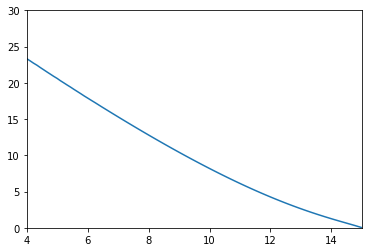

In [5]:
plt.plot(M, z)
plt.xlim(4, 15)
plt.ylim(0, 30)

In [100]:
MT = MergerTree()
ml= 1e6
for i in range(20):
    Ms, zs, M_acc = MT.MT_Routine(1e12, 10, ml)
    # print(np.sum(Ms)+M_acc)
    # print(Ms, M_acc, zs)

<ipython-input-2-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


In [7]:
from itertools import chain

mfinder = np.vectorize(MT.M_finder)

def HalosGenerator(ninput, z):
    r = np.random.uniform(0, 1, ninput)
    y = MT.Delta_c(z)/(np.sqrt(2))/scipy.special.erfinv(r)
    M=mfinder(1e4, y)
    return M

In [79]:
n_halos=1000

Halos = [2.86430509e+08, 5.02566640e+04, 5.75343391e+05, 3.71588083e+04,
       1.25967132e+07, 4.95724013e+05, 1.63703739e+04, 3.57915068e+07,
       4.20201169e+08, 4.04833339e+04, 1.95638987e+08, 7.72203385e+04,
       2.80923376e+04, 4.86148590e+04, 2.99625782e+07, 5.44468693e+05,
       3.69569953e+04, 3.02247258e+04, 3.42988682e+04, 6.56834656e+04,
       3.12373109e+07, 6.70923032e+06, 7.46046218e+06, 1.64516339e+04,
       2.16261123e+04, 1.03959954e+04, 9.96659861e+05, 1.62708840e+08,
       1.07416824e+04, 4.70579801e+09, 3.83068400e+05, 5.44656771e+04,
       5.36377733e+06, 2.14586487e+04, 1.58209846e+06, 1.96199399e+05,
       1.09854894e+07, 4.09058176e+05, 1.77035825e+04, 1.19383639e+06,
       2.44643813e+04, 3.69887978e+05, 3.31452145e+05, 6.88771098e+05,
       1.09044578e+07, 2.48664147e+05, 2.35309385e+04, 2.82535967e+05,
       9.58915890e+06, 2.90455223e+07, 4.91596058e+05, 7.83821124e+04,
       9.94461903e+06, 4.64139358e+06, 2.50994301e+05, 5.39496433e+05,
       1.46565451e+05, 1.24905669e+04, 4.62103604e+05, 6.38660303e+06,
       3.61682869e+05, 1.38700622e+06, 5.08253494e+06, 1.27996706e+04,
       2.51784804e+08, 7.33733909e+04, 1.68729505e+05, 1.37913692e+08,
       7.84163729e+06, 4.51505353e+04, 3.46084525e+05, 9.88162931e+04,
       5.75603066e+06, 4.78930863e+05, 2.11752206e+05, 7.02782756e+06,
       3.01834307e+04, 7.41746729e+05, 7.94216212e+04, 4.22041466e+06,
       2.49672008e+06, 3.03751614e+05, 1.27140559e+05, 2.04330662e+07,
       2.56309455e+05, 4.20076355e+04, 1.52165069e+05, 2.38077552e+04,
       4.86820990e+05, 1.38340461e+04, 4.90736279e+07, 8.42710823e+07,
       5.98128875e+07, 4.12275423e+05, 5.21992775e+05, 2.61904983e+05,
       4.58433522e+07, 6.30131798e+05, 4.40986939e+04, 8.66590449e+06,
       2.15899954e+04, 1.19165452e+06, 9.37573884e+06, 7.73837509e+06,
       2.09937710e+06, 1.51869900e+06, 5.96258512e+04, 1.34631580e+05,
       2.21343739e+09, 1.64115024e+05, 5.32208251e+07, 2.04092560e+05,
       4.24011213e+04, 4.75517888e+06, 4.35696937e+07, 1.25589243e+06,
       6.25269444e+06, 3.39931219e+07, 1.13675687e+06, 5.97454228e+06,
       2.82365271e+06, 1.24735013e+07, 1.66398269e+04, 9.38135461e+04,
       3.86066207e+06, 3.15325393e+05, 2.31065144e+04, 9.82139911e+05,
       2.11669079e+06, 4.16289956e+06, 1.46852443e+07, 2.29797977e+06,
       1.17419589e+06, 4.86414129e+07, 3.44812334e+05, 1.05868733e+04,
       9.01343399e+05, 3.84228745e+04, 1.32425452e+04, 2.21214210e+05,
       1.10841907e+05, 2.12850892e+06, 2.25681215e+06, 1.89044233e+07,
       2.99829559e+05, 1.42965607e+05, 1.64151902e+05, 1.15560240e+07,
       5.04526071e+06, 1.95486884e+04, 1.23379692e+05, 5.48872300e+04,
       3.12699309e+04, 4.01198110e+05, 1.20948946e+08, 3.57883732e+04,
       5.02533675e+06, 1.75256905e+05, 1.20219057e+04, 9.83826448e+05,
       5.18393340e+05, 1.86297282e+07, 3.72873581e+05, 1.67158376e+06,
       6.67118243e+04, 5.05406958e+06, 6.51317466e+04, 1.33563587e+07,
       4.26601144e+05, 1.64960955e+04, 2.62017293e+04, 7.04945221e+07,
       1.84274473e+07, 3.58946769e+05, 8.15131225e+05, 5.39844816e+08,
       1.01554237e+04, 5.83397732e+06, 5.08167540e+05, 2.05556999e+05,
       1.89606970e+06, 2.62798640e+04, 3.14735201e+06, 1.30865600e+04,
       8.82108612e+06, 1.27035908e+05, 1.25051961e+04, 1.14013467e+04,
       3.57201460e+04, 3.33229612e+05, 2.17509421e+04, 5.33882774e+06,
       1.94512682e+04, 1.48443847e+07, 5.67831579e+04, 3.11160235e+07,
       4.80973128e+05, 3.20607762e+06, 3.67121020e+06, 1.00244217e+06,
       8.44064178e+07, 3.62799330e+07, 6.36876485e+04, 7.94691480e+04,
       1.85815184e+05, 1.76645875e+04, 3.85875808e+06, 6.88033068e+05,
       1.89461499e+04, 2.55874477e+07, 6.19282064e+06, 1.41338276e+04,
       6.08893871e+04, 3.12064642e+04, 2.99619419e+04, 5.44652505e+04,
       2.67482213e+05, 1.02386951e+08, 3.46946206e+06, 8.89299334e+04,
       3.18060020e+08, 3.43249138e+06, 3.07378426e+06, 5.78729591e+07,
       4.90747223e+05, 2.84289844e+05, 9.24573449e+04, 1.27822006e+08,
       1.31346053e+05, 2.34504736e+04, 1.13849492e+07, 6.02224252e+08,
       7.53086924e+06, 7.60813487e+09, 6.46758105e+04, 1.00043615e+07,
       5.57943554e+04, 9.60219927e+06, 1.91493091e+05, 1.52924671e+05,
       7.74216636e+05, 7.65779151e+04, 3.55671645e+05, 3.51072395e+05,
       1.37081531e+08, 1.10689429e+05, 8.26128189e+06, 2.60119216e+05,
       1.09758542e+04, 1.77070732e+05, 7.26626070e+07, 3.47926101e+04,
       2.12632059e+05, 1.15095263e+06, 7.06757853e+07, 2.31089202e+04,
       5.81687408e+06, 1.77906897e+07, 2.48649832e+08, 7.56479511e+05,
       1.50473827e+04, 4.89710235e+05, 7.39030989e+05, 6.59162160e+07,
       3.79705964e+07, 2.58232025e+06, 8.62555802e+07, 3.81496144e+06,
       1.58819861e+04, 3.91935605e+07, 1.71132864e+06, 1.45352479e+06,
       9.68769005e+08, 1.36457864e+04, 1.00046834e+06, 7.45240309e+04,
       9.04573453e+05, 4.40130945e+08, 2.12141996e+06, 8.54098221e+04,
       5.06660401e+05, 1.23395903e+06, 1.90235856e+05, 5.38770299e+04,
       1.59976141e+04, 1.25100443e+05, 6.27772556e+05, 7.25525214e+05,
       1.64014496e+07, 3.77616966e+07, 2.37969199e+06, 1.01954817e+06,
       1.44644173e+04, 2.17513891e+07, 1.36086678e+07, 1.03137585e+08,
       1.34284129e+05, 1.95405643e+05, 1.80871235e+04, 1.81658809e+04,
       2.65106814e+06, 4.30424613e+07, 3.91535423e+05, 5.71081420e+08,
       7.09023394e+07, 7.87751147e+07, 3.23710061e+05, 6.36484120e+07,
       1.13487491e+04, 5.18726552e+08, 1.23359066e+06, 3.20448592e+05,
       1.19133707e+07, 1.97515844e+05, 4.34842412e+06, 1.09546740e+05,
       2.08600901e+04, 2.46636711e+04, 3.28488844e+04, 5.07049601e+06,
       1.00198034e+04, 1.01551496e+08, 7.32577791e+05, 1.69581736e+06,
       1.54085118e+06, 3.12197583e+05, 1.05241143e+05, 1.60579144e+06,
       3.38804469e+07, 1.98774123e+08, 8.58559801e+04, 3.06473798e+05,
       2.17498090e+05, 6.55477431e+05, 2.98999069e+05, 1.01817551e+04,
       5.76628150e+05, 3.10067188e+04, 3.98775645e+08, 6.93333563e+05,
       5.42059905e+04, 3.79406076e+06, 4.36500146e+06, 3.91835257e+05,
       1.61897895e+07, 4.64028186e+04, 1.69331943e+07, 1.01277462e+05,
       1.56509101e+05, 9.75606020e+04, 3.97735627e+06, 5.63350322e+06,
       1.39367281e+04, 4.70605223e+05, 3.25156756e+07, 2.79573508e+04,
       2.48406675e+04, 2.42357150e+07, 2.33881126e+05, 2.05231698e+08,
       6.92114687e+04, 4.17021890e+07, 2.27872918e+07, 1.81221970e+07,
       2.53521585e+05, 6.38117419e+04, 2.56843585e+05, 2.00093218e+08,
       9.31312434e+04, 1.48456874e+08, 5.76452349e+07, 1.52358962e+05,
       1.00490796e+05, 9.52268671e+05, 5.19191162e+05, 1.85299192e+04,
       6.95101369e+04, 1.30573716e+05, 3.78474582e+07, 3.83701880e+04,
       1.03167316e+08, 1.03693707e+04, 1.77717053e+04, 3.47807370e+06,
       1.56361510e+05, 3.28403527e+04, 1.06484470e+07, 6.33381828e+05,
       7.28024321e+05, 4.51944799e+06, 5.06290930e+09, 1.28544154e+04,
       2.37735153e+08, 3.61195744e+06, 1.28914410e+06, 2.20759830e+07,
       1.04367862e+05, 1.59491879e+05, 5.27662702e+05, 2.32290620e+05,
       2.91244696e+04, 5.30149796e+08, 3.76615883e+04, 9.95545037e+06,
       1.78248593e+08, 7.07245641e+06, 1.12188519e+04, 9.25940708e+07,
       2.34903414e+06, 7.74466446e+05, 1.17510771e+07, 3.25771607e+05,
       1.02668335e+04, 3.77215747e+05, 6.56370040e+04, 3.38137249e+06,
       6.07635165e+09, 1.96892205e+06, 1.10765332e+05, 6.97819231e+05,
       1.61411176e+07, 4.26572415e+07, 1.70867412e+08, 3.52058287e+05,
       1.75767760e+07, 6.73167430e+05, 6.25765980e+05, 1.36916590e+06,
       1.44797423e+06, 1.24065509e+06, 1.19607487e+04, 3.62018284e+05,
       1.58958867e+04, 1.40880460e+06, 1.72276718e+06, 1.32361641e+04,
       3.51299026e+04, 1.51550922e+08, 3.11157966e+06, 4.62481688e+07,
       2.66583142e+07, 8.95981196e+04, 1.75970350e+04, 3.95615801e+04,
       3.24641552e+08, 3.65407980e+06, 1.68640558e+07, 2.74085866e+07,
       7.63013110e+06, 1.25997050e+04, 1.75050511e+04, 3.17925398e+04,
       3.16911145e+05, 1.01792396e+06, 9.58137719e+04, 8.80998328e+04,
       2.32436391e+04, 5.88340645e+04, 4.11124925e+06, 3.92067446e+05,
       7.28133862e+08, 2.64048943e+04, 5.69732499e+06, 5.24816618e+04,
       1.81233178e+06, 2.20863865e+04, 2.37750095e+04, 1.37942276e+06,
       3.77755927e+07, 7.31279751e+04, 2.69498449e+06, 6.81003070e+06,
       2.65393811e+05, 4.47584142e+06, 1.94528513e+04, 1.69849757e+05,
       1.24534568e+04, 1.60400457e+04, 1.80639011e+04, 4.94808946e+05,
       1.42345927e+07, 2.54962996e+05, 4.06762885e+05, 1.07920950e+07,
       1.44303925e+04, 6.50293801e+08, 2.65673575e+04, 6.27188208e+04,
       1.97520717e+04, 8.14850661e+04, 9.57574473e+04, 4.41298002e+06,
       8.40398375e+04, 3.53446182e+07, 3.47782256e+09, 2.77793414e+08,
       8.81779259e+05, 2.90972119e+04, 3.93284233e+08, 5.50852318e+04,
       6.80960086e+08, 2.16719843e+04, 4.45031079e+07, 3.57561848e+04,
       2.44765813e+04, 1.76377853e+04, 1.66862683e+04, 1.20680637e+08,
       2.83567446e+04, 3.11723232e+09, 1.94515049e+05, 8.49339933e+04,
       2.32725497e+07, 1.06247829e+06, 1.05872836e+08, 2.08813600e+07,
       1.32459461e+04, 6.00991596e+07, 1.07237187e+04, 4.39563081e+08,
       7.08954238e+08, 2.17165233e+05, 7.51038398e+04, 2.60901967e+08,
       1.10911368e+07, 6.68269347e+04, 6.18323948e+05, 2.46906839e+06,
       2.17677487e+08, 1.66705585e+05, 5.67378761e+05, 1.56558712e+06,
       1.14620165e+06, 1.54429537e+06, 3.46840872e+06, 3.25844211e+04,
       1.09009701e+05, 5.63706701e+04, 5.12953261e+06, 1.41632671e+06,
       9.47619918e+06, 2.24571792e+07, 8.36149299e+06, 2.18690365e+05,
       5.96269015e+06, 1.01178361e+07, 1.12110538e+08, 2.34192648e+04,
       1.80019590e+06, 5.39785610e+08, 2.28735607e+04, 1.07578814e+08,
       3.38003744e+09, 2.15011872e+05, 1.41799001e+07, 2.30589568e+04,
       2.85741931e+04, 3.41886435e+04, 2.60199582e+08, 1.19237440e+08,
       8.34887481e+04, 8.51204861e+05, 7.31956027e+05, 2.61820557e+06,
       6.91603133e+04, 1.68813198e+07, 4.84869226e+08, 4.50978477e+04,
       3.88009173e+04, 2.02452041e+06, 2.87486456e+06, 5.41866913e+06,
       1.08467512e+04, 3.44618502e+05, 8.67440913e+06, 1.07487121e+04,
       1.09982545e+05, 7.00268370e+06, 3.65626383e+07, 1.80577250e+06,
       3.01133969e+05, 2.37840302e+06, 9.74495996e+04, 8.28780011e+05]

In [20]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 10, 100)

<ipython-input-2-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]


In [21]:
def halo_PDF_norm(z):
    return integrate.quad(HIMF.IMF, 10**4, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]

In [72]:
Himf_10 = HIMF.IMF(m, 10)/halo_PDF_norm(10)

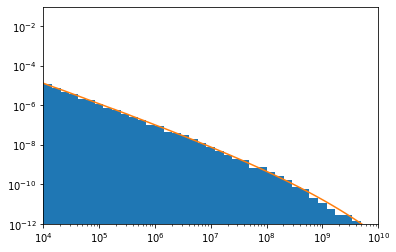

In [73]:
plt.hist(Halos, density=True, bins=10**np.linspace(4, 10, 40))
M=np.logspace(4, 10, 100)
plt.plot(M, Himf_10)
plt.xlim(10**4, 10**10)
plt.ylim(1e-12,1e-1)
plt.xscale('log')
plt.yscale('log')

In [126]:
z=10
ml = 1e4
Ms=Halos[:50]
while z<30:
    Mss=[]
    Z=[]
    for ii in range(len(Ms)):
        routine = MT.MT_Routine(Ms[ii], z , ml)
        Z.append(routine[1])
        Mss.append(routine[0])
        
    z=np.max(Z)

    print(z)

    Mss = list(chain.from_iterable(Mss))
    Ms = Mss
    # print(Ms)

/Users/antoninpantalacci/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


14.646070627634861
20.011388255657263
24.48610404896242
29.81070650742155
34.269372248109256


In [137]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 10, 100)
Himf = HIMF.IMF(m, 30)/halo_PDF_norm(30)

<ipython-input-2-7d702abe1997>:232: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-2, limit=200)[0]
<ipython-input-21-098ffc4d763d>:2: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(HIMF.IMF, 10**4, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]


(10000.0, 1e+18)

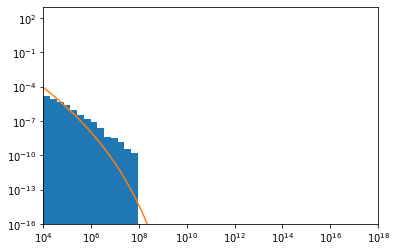

In [138]:
plt.hist(Ms, bins=10**np.linspace(4,15,40), log=True, density=True)
plt.plot(m, Himf)
# plt.plot(m, Himf_10)
plt.ylim(1e-16,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 1e18)

In [128]:
len(Ms)

602